# How does TMDL grandfathering affect NPDES limit values?
The hypothesis driving this exploration is that facilities built on water bodies prior to TMDLs being created on those water bodies may be assigned *less* responsibility to reduce discharges (i.e., higher NPDES limits), when compared to facilities built after TMDLs are established (in essence, their old limits may be 'grandfathered' in post-TMDL).

In a prior version of this exploration, I looked into whether limit values on permits issued prior to TMDLs are lower than limit values on permits issued post-TMDL (irrespective of facility age), and found inconclusive results.

Author: Ryan Treves

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [173]:
# Load ATTAINS & RAD data
tmdls = pd.read_csv('all_actions.csv', parse_dates=['TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).rename(columns={'assessmentUnitIdentifier':'AUID'})
huc_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object}).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})
huc_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object}).rename(columns={'attributes.assessmentunitidentifier':'AUID', 'attributes.huc12': 'HUC-12'})

# Load ICIS-NPDES permit data
permit_data = pd.read_csv('permit_data.csv', parse_dates=['effective_date', 'issue_date', 'original_effective_date', 'original_issue_date', 'expiration_date', 'retirement_date', 'termination_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))

In [3]:
# Link TMDLs to HUC-12 codes to NPDES permittees
tmdls_merged = tmdls.drop_duplicates().merge(huc_AUID_links, on='AUID', how='inner').merge(huc_npdes_permit_links, on='HUC-12', how='inner')

# Filter down to point-source TMDLs
tmdls_merged = tmdls_merged[tmdls_merged['pollutantSourceTypeCode'] != 'Nonpoint source']

# Deleting objects we no longer need to save memory
del tmdls
del huc_AUID_links
del huc_npdes_permit_links

In [177]:
tmdls_merged['pollutantName'].value_counts()

IRON                                                            1551350
ALUMINUM                                                        1486115
MANGANESE                                                       1395822
PH                                                               905329
SEDIMENT                                                         601937
POLYCHLORINATED BIPHENYLS (PCBS)                                 262655
ESCHERICHIA COLI (E. COLI)                                       233548
PHOSPHORUS                                                       208988
FECAL COLIFORM                                                   192532
CHLORDANE                                                        181370
PHOSPHORUS, TOTAL                                                147802
NITROGEN, TOTAL                                                   99917
TOTAL SUSPENDED SOLIDS (TSS)                                      70937
MERCURY                                                         

Instead of looking at all TMDLs nationally at once, let's look at one pollutant at a time.
First, let's define a function to merge NPDES limits with TMDLs for a given parameter:

In [203]:
def merge_limits_tmdls(pollutants, dmr_path, permit_data, tmdl_data):
    # Read in DMR data for limit comparisons and drop rows with NA limit values
    dmrs = pd.read_csv(dmr_path, parse_dates=['limit_begin_date', 'limit_end_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).dropna(subset='limit_value_standard_units')

    # Extract only limits from DMR data
    limits = dmrs.drop_duplicates(subset=['npdes_permit_id', 'perm_feature_nmbr', 'parameter_desc', 'limit_value_type_code', 'limit_value_nmbr', 'statistical_base_code', 'limit_begin_date', 'version_nmbr'])
    del dmrs

    # Merge with permit_data to get permit issuance date
    limits = limits.merge(permit_data, on=['npdes_permit_id', 'version_nmbr'], how='left')

    # Retain only TMDLs for the given parameter
    tmdl_data = tmdl_data[tmdl_data['pollutantName'].apply(lambda x: x in pollutants)]
    # Merge limit data with TMDL data
    limits_merged = tmdl_data.merge(limits, on='npdes_permit_id', how='inner')

    # Drop limits that expired, retired, or were terminated before the TMDL date
    limits_merged = limits_merged[~(limits_merged['expiration_date'] <= limits_merged['TMDLDate']) &
                                              ~(limits_merged['retirement_date'] <= limits_merged['TMDLDate']) &
                                              ~(limits_merged['termination_date'] <= limits_merged['TMDLDate'])]
    # Define incumbency and old/new facility
    limits_merged['incumbent'] = (limits_merged['issue_date'] <= limits_merged['TMDLDate'])
    limits_merged['new_facility'] = (limits_merged['original_issue_date'] > limits_merged['TMDLDate'])

    return limits_merged

Next, let's define a function to test how different limit values are between new and old facilities of the same limit value type and base code within the same TMDL, for the same pollutant:

In [229]:
def test_facility_limit_diffs(limits):
    # Group by limit type
    grouped = limits.groupby(['pollutantName', 'pollutantSourceTypeCode', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], as_index=False).nunique()

    # Only retain permit limit types with more than one permittee, as well as both new and old facilities
    grouped = grouped[(grouped['npdes_permit_id'] > 1) & (grouped['new_facility'] > 1)]

    # Set up table to collect test results
    all_stats = pd.DataFrame()

    for i in range(0, len(grouped)):
        # Pick out one permit limit type
        permit_limit_type = grouped.iloc[[i]][
            ['pollutantName', 'pollutantSourceTypeCode', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier']].merge(limits,
                                        on=['pollutantName', 'pollutantSourceTypeCode', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], how='inner')

        # Create ID tracking unique limits
        permit_limit_type['unique_lim_id'] = permit_limit_type['npdes_permit_id'] + '_' + permit_limit_type[
            'version_nmbr'].astype(str) + '_' + permit_limit_type['perm_feature_nmbr'].astype(str) + '_' + permit_limit_type['limit_begin_date'].astype(str)

        # Drop non-unique limits
        permit_limit_type.drop_duplicates('unique_lim_id', inplace=True)

        # Calculate test results
        stats = permit_limit_type.groupby(['pollutantName', 'pollutantSourceTypeCode', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier', 'new_facility'], as_index=False).agg(limit_mean=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.mean()), limit_mean_SE=pd.NamedAgg(column='limit_value_standard_units', aggfunc=lambda x: x.sem()), unique_limits=pd.NamedAgg(column='unique_lim_id', aggfunc=lambda x: x.nunique()))
        stats = pd.pivot(stats, index=['pollutantName', 'pollutantSourceTypeCode', 'limit_value_type_code', 'statistical_base_code', 'actionIdentifier'], columns='new_facility')
        stats.columns = ['Old_facility_limit_mean', 'New_facility_limit_mean', 'Old_facility_limit_SE', 'New_facility_limit_SE', 'Old_facility_unique_limits', 'New_facility_unique_limits']
        stats['old>new'] = list(map(str, stats['Old_facility_limit_mean']>stats['New_facility_limit_mean']))
        all_stats = pd.concat([all_stats, stats.reset_index()])
    return all_stats.reset_index()

### Phosphorus

In [230]:
# Merge limits with TMDLs and run difference test
P_limits_merged = merge_limits_tmdls(['PHOSPHORUS, TOTAL', 'PHOSPHORUS'], 'phosphorus_dmrs.csv', permit_data, tmdls_merged)
results = test_facility_limit_diffs(P_limits_merged)
results

,index,pollutantName,pollutantSourceTypeCode,limit_value_type_code,statistical_base_code,actionIdentifier,Old_facility_limit_mean,New_facility_limit_mean,Old_facility_limit_SE,New_facility_limit_SE,Old_facility_unique_limits,New_facility_unique_limits,old>new
0,0,PHOSPHORUS,Both,C2,3F,2055,0.711111,1.000000,0.119541,0.000000e+00,9,6,False
1,0,PHOSPHORUS,Both,C2,3F,841,0.711111,1.000000,0.119541,0.000000e+00,9,6,False
2,0,PHOSPHORUS,Both,C2,MK,242,1.000000,1.000000,0.000000,0.000000e+00,10,2,False
3,0,PHOSPHORUS,Both,C2,MK,245,1.000000,1.000000,0.000000,0.000000e+00,10,2,False
4,0,PHOSPHORUS,Both,C2,MK,249,1.911765,2.000000,0.047653,0.000000e+00,17,2,False
5,0,PHOSPHORUS,Both,C2,MK,250,0.651163,4.000000,0.067659,0.000000e+00,43,4,False
6,0,PHOSPHORUS,Both,C2,MK,304,2.000000,2.000000,0.000000,0.000000e+00,15,5,False
7,0,PHOSPHORUS,Both,C2,MK,308,1.413043,2.000000,0.156076,0.000000e+00,23,4,False
8,0,PHOSPHORUS,Both,C2,MK,309,1.413043,2.000000,0.156076,0.000000e+00,23,4,False
9,0,PHOSPHORUS,Both,C2,MK,312,1.604651,1.777778,0.090462,1.469862e-01,43,9,False


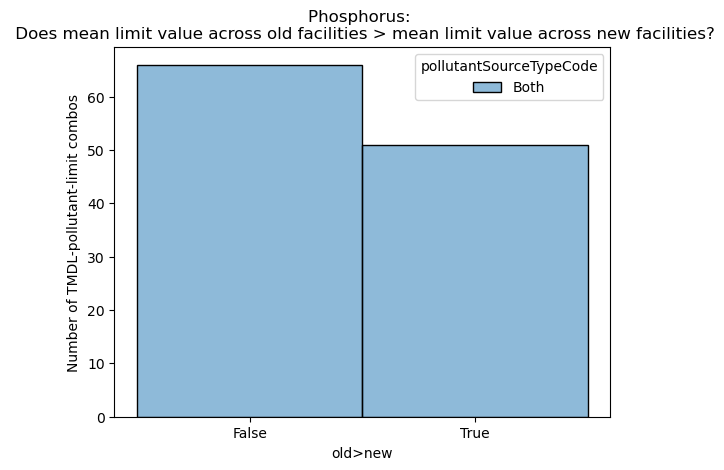

In [228]:
# Plot results
plt.style.use('default')
plt.title('Phosphorus: \n Does mean limit value across old facilities > mean limit value across new facilities?');
plt.ylabel('Number of TMDL-pollutant-limit combos')
sns.histplot(data=results[['old>new', 'pollutantSourceTypeCode']], x='old>new', hue='pollutantSourceTypeCode');

### Mercury

In [231]:
# Merge limits with TMDLs and run difference test
Hg_limits_merged = merge_limits_tmdls('MERCURY', 'mercury_dmrs.csv', permit_data, tmdls_merged)
results = test_facility_limit_diffs(Hg_limits_merged)
results

,index,pollutantName,pollutantSourceTypeCode,limit_value_type_code,statistical_base_code,actionIdentifier,Old_facility_limit_mean,New_facility_limit_mean,Old_facility_limit_SE,New_facility_limit_SE,Old_facility_unique_limits,New_facility_unique_limits,old>new
0,0,MERCURY,Both,C2,1D,MI-2018-002,0.000005,1.000000e-05,7.024613e-07,NaN,106,1,False
1,0,MERCURY,Both,C2,MK,33994,0.000948,2.000000e-05,8.869871e-04,NaN,89,1,True
2,0,MERCURY,Both,C2,MK,37909,0.000400,1.347800e-03,NaN,2.774205e-04,1,10,False
3,0,MERCURY,Both,C2,MK,38859,0.000040,2.000000e-05,5.720751e-06,NaN,19,1,True
4,0,MERCURY,Both,C2,MK,IL-2019-002,0.000001,1.300000e-06,0.000000e+00,0.000000e+00,8,2,False
5,0,MERCURY,Both,C3,1D,32414,0.000007,6.900000e-06,NaN,NaN,1,1,False
6,0,MERCURY,Both,C3,DD,11082,0.000132,8.666667e-04,3.461211e-05,4.216370e-05,14,6,False
7,0,MERCURY,Both,C3,DD,11083,0.000346,7.616279e-04,1.344600e-04,6.067718e-05,37,43,False
8,0,MERCURY,Both,C3,DD,33994,0.004941,4.100000e-05,4.603725e-03,NaN,26,1,True
9,0,MERCURY,Both,C3,DD,37909,0.009183,2.592963e-03,6.269738e-03,4.448479e-04,6,54,True


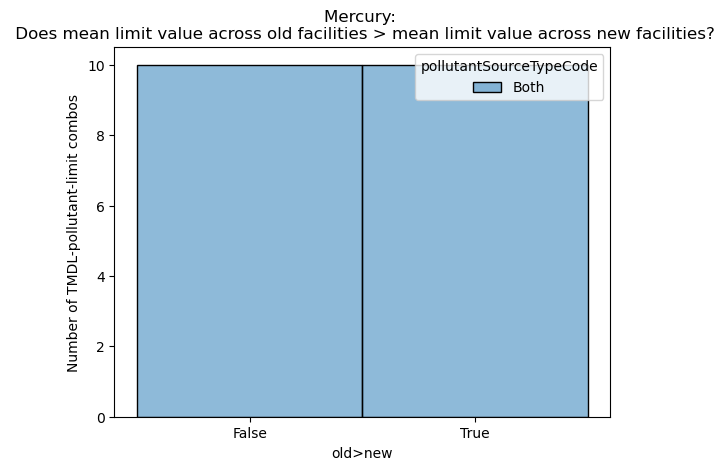

In [232]:
plt.style.use('default')
plt.title('Mercury: \n Does mean limit value across old facilities > mean limit value across new facilities?');
plt.ylabel('Number of TMDL-pollutant-limit combos')
sns.histplot(data=results[['old>new', 'pollutantSourceTypeCode']], x='old>new', hue='pollutantSourceTypeCode');